In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
data = pd.read_csv("03_employee_retention_data.csv", parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [5]:
# Check Null Value
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [6]:
data['quit_date'].isnull().astype(int)

0        0
1        0
2        1
3        0
4        0
        ..
24697    1
24698    1
24699    0
24700    0
24701    0
Name: quit_date, Length: 24702, dtype: int32

# Create a table to include day, employee_headcount and company_id information

In [7]:
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day =[]
company = []
headcount = []

# loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# create table to include day, employee_headcount and company_id infomation
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                    columns=['day', 'company_id', 'employee_headcount'])

In [8]:
table.head(12)

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
5,2011-01-24,6,3
6,2011-01-24,7,1
7,2011-01-24,8,6
8,2011-01-24,9,3
9,2011-01-24,10,0


# Employee Churn Analysis

In [9]:
stay_data = data[data['quit_date'].isnull()]
quit_data = data[~data['quit_date'].isnull()]
quit_data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30
...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09


## Feature Engineering

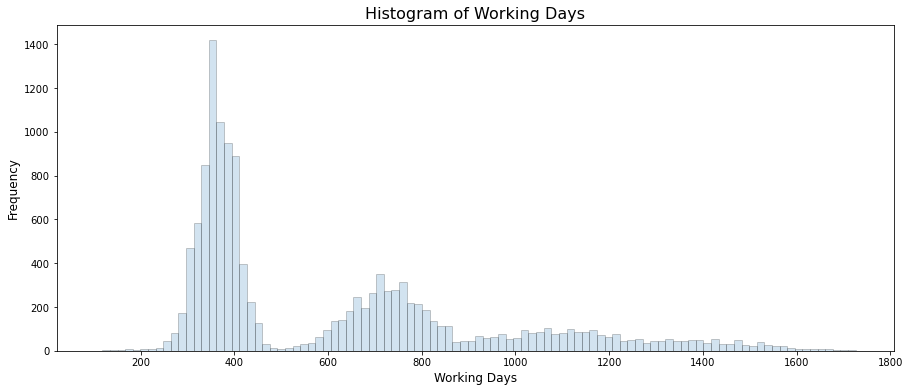

In [10]:
# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date']))) 
# https://book.pythontips.com/en/latest/map_filter.html

hist_kws = {'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

when the work days are around 365, it has the highest chance to quit.

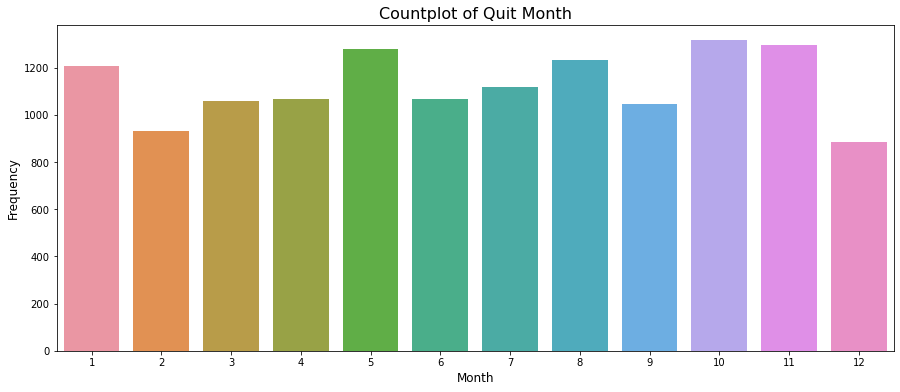

In [11]:
# Month No. for quiting
quit_month = np.array(list(map(lambda x:x.month, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_month, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

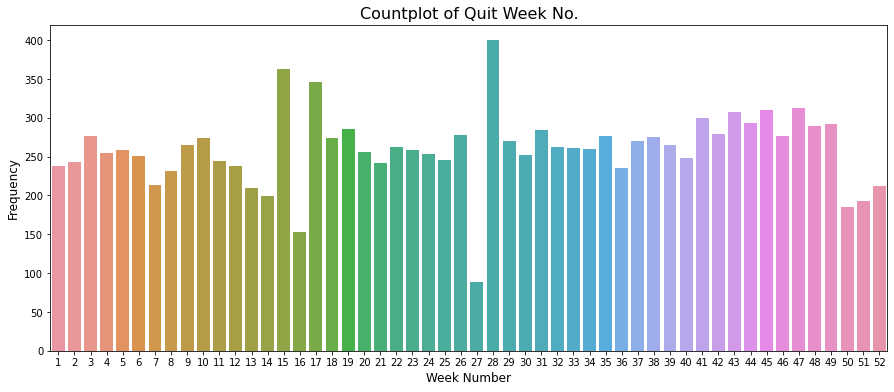

In [12]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x:x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [13]:
quit_data['work_days'] = work_days
quit_data['quit_month'] = quit_month
quit_data['quit_week'] = quit_week
quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_month,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,10,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,4,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,6,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,8,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,8,35


## Decision Tree Model

In [14]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [15]:
# 12 months
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365)
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 12 months)
# stay more than 12 months
not_quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=365))

subset['if_work_less_than_a_year'] = 1 - not_quit.astype(int)
subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,if_work_less_than_a_year
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [16]:
# label encoder
le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = LabelEncoder().fit_transform(subset['dept'])
train_y = subset['if_work_less_than_a_year'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [17]:
# build decision tree

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

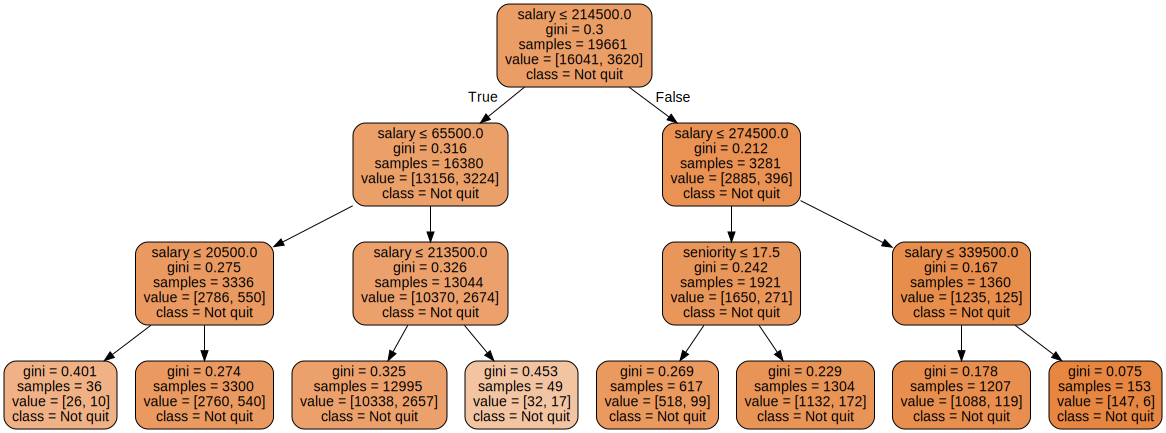

In [18]:
# visualization
features = list(train_x.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets,
                               filled=True, rounded=True, special_characters=True,)
graph = graphviz.Source(dot_data)
graph

In [27]:
# feature importance
# importance = sorted()
importance = sorted(zip(features, clf.feature_importances_), reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

seniority  | 0.01404
salary     | 0.98596
dept       | 0.00000
company_id | 0.00000


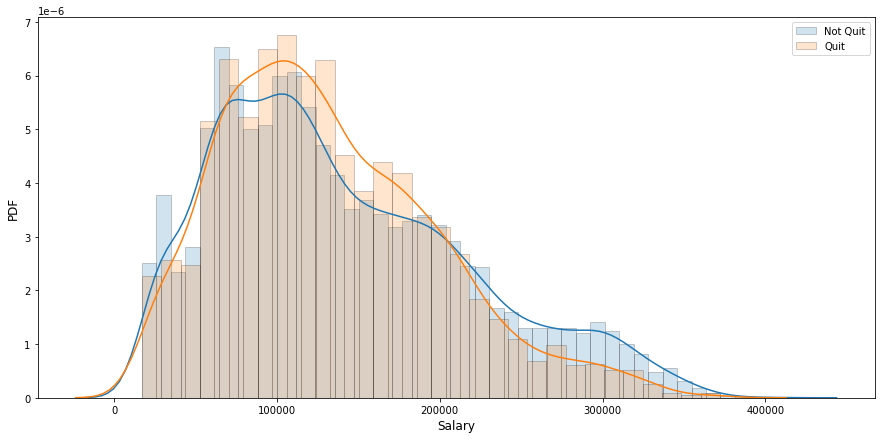

In [29]:
# visalization
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(subset[subset['if_work_less_than_a_year']==0]['salary'], label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['if_work_less_than_a_year']==1]['salary'], label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

# other Factors

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting. 
2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3. Employees with high salaries are less likely to quit. Probably because employees with high salaries are happy at their current job. And employees with salary range from 90K t0 180K are more likely to quick than other salary range. 